# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2025-12-06 17:36:38.414070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765038998.429020   84739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765038998.433496   84739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765038998.445749   84739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765038998.445774   84739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765038998.445776   84739 computation_placer.cc:177] computation placer alr

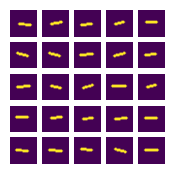

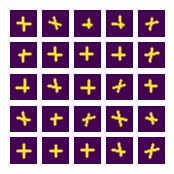

In [4]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2468

X_text: "12+34" = y_text: "46 "


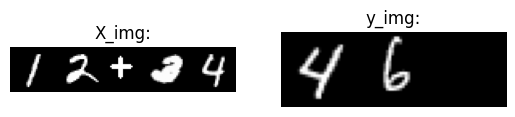

Query #6201

X_text: "31-0 " = y_text: "31 "


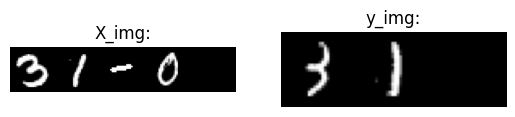

Query #8212

X_text: "41+6 " = y_text: "47 "


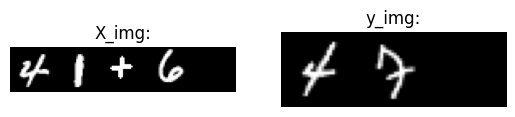

Query #7338

X_text: "36+69" = y_text: "105"


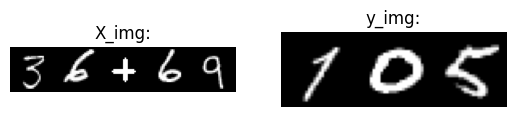

Query #3643

X_text: "18-21" = y_text: "-3 "


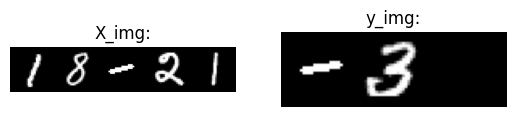

Query #9297

X_text: "46-48" = y_text: "-2 "


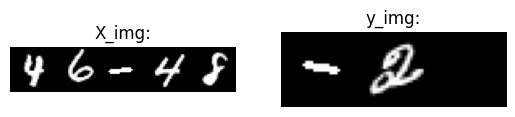

Query #9857

X_text: "49-28" = y_text: "21 "


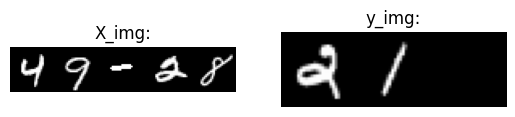

Query #4437

X_text: "22-18" = y_text: "4  "


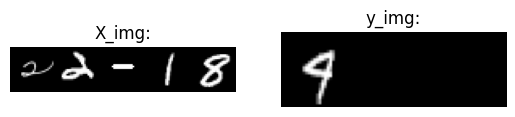

Query #240

X_text: "1+20 " = y_text: "21 "


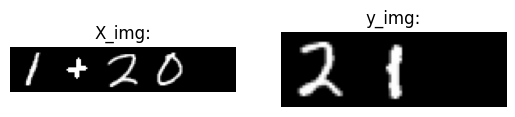

Query #8414

X_text: "42+7 " = y_text: "49 "


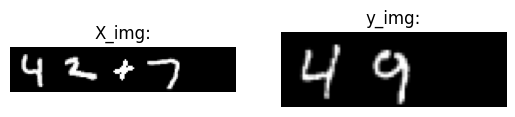

In [6]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [11]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

## Build Text2Text Model

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [15]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)
text2text = build_text2text_model()

/home/jaspe/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_text_onehot,y_text_onehot,test_size=.4, random_state=5)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=.5, random_state=10)

hist_t2t = text2text.fit(
    X_train,y_train,
    validation_data = (X_val,y_val),
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3800 - loss: 1.8289 - val_accuracy: 0.4263 - val_loss: 1.5695
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4788 - loss: 1.4411 - val_accuracy: 0.5244 - val_loss: 1.3213
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5422 - loss: 1.2576 - val_accuracy: 0.5653 - val_loss: 1.1820
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5682 - loss: 1.1691 - val_accuracy: 0.5800 - val_loss: 1.1313
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5918 - loss: 1.0994 - val_accuracy: 0.5936 - val_loss: 1.1053
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6040 - loss: 1.0582 - val_accuracy: 0.6020 - val_loss: 1.0473
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6232 - loss: 1.0073 - val_accuracy: 0.6199 - val_loss: 1.0154
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6341 - loss: 0.9774 - val_accu

In [17]:
x = '94+6 '
x = encode_labels(x)
x = x.reshape(1,5,13)

In [18]:
pred = text2text.predict(x)
decode_labels(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


['100']

In [19]:
from collections import Counter
pred = decode_labels(text2text.predict(X_test))
pred = ['0  ' if a == '-  ' else a for a in pred]
true = decode_labels(y_test)
# print(np.where(np.array([abs(int(t)-int(p)) for t, p in zip(true,pred)]) == 800))

results = Counter([abs(int(t)-int(p)) for t, p in zip(true,pred) if t != p])
results = [(k,results[k]) for k in sorted(results.keys())]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


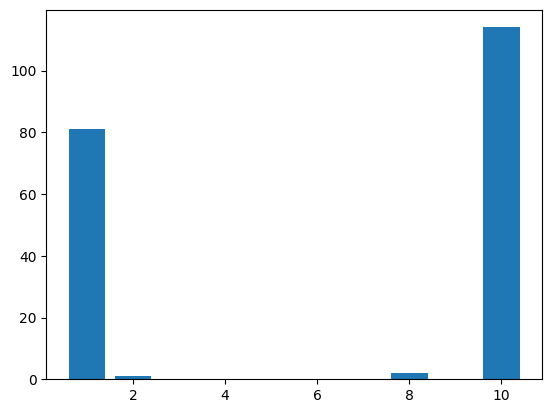

In [ ]:
fig,ax = plt.subplots()
x = [a[0] for a in results]
y = [a[1] for a in results]
ax.bar(x[:4],y[:4])
plt.show()

## Experiment with differnet Train Test Splits

In [22]:
def train_test_split_experiment(model_builder = build_text2text_model,splits = [0.75,0.5,0.4,0.3,0.25,0.2,0.1], random_states = [0,1,2,3,4,5,6]):
    hists = []
    models = []
    for split,seed in zip(splits, random_states):
        text2text = model_builder()
        X_train,X_test,y_train,y_test = train_test_split(X_text_onehot,y_text_onehot,test_size=split, random_state=seed)

        hist_t2t = text2text.fit(
            X_train,y_train,
            validation_data = (X_test,y_test),
            epochs = 50,
            batch_size = 32
        )
        hists.append(hist_t2t)
        models.append(text2text)
    return hists, models

In [23]:
hists,models = train_test_split_experiment(model_builder=build_default_text2text_model)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3433 - loss: 2.0322 - val_accuracy: 0.3988 - val_loss: 1.7916
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4070 - loss: 1.6981 - val_accuracy: 0.4162 - val_loss: 1.6619
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4469 - loss: 1.5412 - val_accuracy: 0.4381 - val_loss: 1.5091
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4792 - loss: 1.4300 - val_accuracy: 0.4930 - val_loss: 1.4140
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5091 - loss: 1.3525 - val_accuracy: 0.5321 - val_loss: 1.3008
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5335 - loss: 1.2851 - val_accuracy: 0.5108 - val_loss: 1.3352
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5536 - loss: 1.2301 - val_accuracy: 0.5445 - val_loss: 1.2143
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5573 - loss: 1.2112 - val_accu

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3685 - loss: 1.8867 - val_accuracy: 0.4158 - val_loss: 1.6194
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4593 - loss: 1.4939 - val_accuracy: 0.4641 - val_loss: 1.4554
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5143 - loss: 1.3289 - val_accuracy: 0.5398 - val_loss: 1.2582
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5591 - loss: 1.2067 - val_accuracy: 0.5956 - val_loss: 1.1271
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5838 - loss: 1.1382 - val_accuracy: 0.5955 - val_loss: 1.0933
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5987 - loss: 1.0880 - val_accuracy: 0.6050 - val_loss: 1.0674
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6117 - loss: 1.0483 - val_accuracy: 0.6227 - val_loss: 1.0275
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6234 - loss: 1.0179 - val_accu

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3806 - loss: 1.8323 - val_accuracy: 0.4423 - val_loss: 1.5709
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4780 - loss: 1.4414 - val_accuracy: 0.5236 - val_loss: 1.3239
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5346 - loss: 1.2754 - val_accuracy: 0.5585 - val_loss: 1.2209
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5704 - loss: 1.1759 - val_accuracy: 0.5780 - val_loss: 1.1390
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5876 - loss: 1.1182 - val_accuracy: 0.6083 - val_loss: 1.0685
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6061 - loss: 1.0582 - val_accuracy: 0.6212 - val_loss: 1.0230
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6210 - loss: 1.0189 - val_accuracy: 0.6286 - val_loss: 0.9891
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6350 - loss: 0.9789 - val_accu

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3880 - loss: 1.7925 - val_accuracy: 0.4707 - val_loss: 1.4888
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4989 - loss: 1.3791 - val_accuracy: 0.5313 - val_loss: 1.2819
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5531 - loss: 1.2231 - val_accuracy: 0.5661 - val_loss: 1.1786
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5792 - loss: 1.1321 - val_accuracy: 0.5907 - val_loss: 1.1090
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5995 - loss: 1.0711 - val_accuracy: 0.6002 - val_loss: 1.0600
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6145 - loss: 1.0271 - val_accuracy: 0.6044 - val_loss: 1.0426
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6296 - loss: 0.9889 - val_accuracy: 0.6314 - val_loss: 0.9817
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6461 - loss: 0.9502 - val_accu

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3924 - loss: 1.7877 - val_accuracy: 0.4655 - val_loss: 1.4848
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5050 - loss: 1.3650 - val_accuracy: 0.5292 - val_loss: 1.2676
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5576 - loss: 1.2014 - val_accuracy: 0.5761 - val_loss: 1.1417
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5950 - loss: 1.1025 - val_accuracy: 0.6052 - val_loss: 1.0569
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6115 - loss: 1.0429 - val_accuracy: 0.6140 - val_loss: 1.0225
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6273 - loss: 1.0006 - val_accuracy: 0.6376 - val_loss: 0.9705
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6372 - loss: 0.9682 - val_accuracy: 0.6564 - val_loss: 0.9242
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6523 - loss: 0.9253 - val_accu

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3988 - loss: 1.7443 - val_accuracy: 0.4777 - val_loss: 1.4693
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5090 - loss: 1.3493 - val_accuracy: 0.5292 - val_loss: 1.2661
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5652 - loss: 1.1859 - val_accuracy: 0.5853 - val_loss: 1.1289
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5975 - loss: 1.0865 - val_accuracy: 0.5898 - val_loss: 1.1105
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6169 - loss: 1.0246 - val_accuracy: 0.6062 - val_loss: 1.0461
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6345 - loss: 0.9788 - val_accuracy: 0.6363 - val_loss: 0.9691
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6470 - loss: 0.9411 - val_accuracy: 0.6467 - val_loss: 0.9437
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6649 - loss: 0.8966 - val_accur

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4017 - loss: 1.7373 - val_accuracy: 0.4775 - val_loss: 1.4172
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5183 - loss: 1.3206 - val_accuracy: 0.5705 - val_loss: 1.1856
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5755 - loss: 1.1555 - val_accuracy: 0.6077 - val_loss: 1.0783
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6044 - loss: 1.0677 - val_accuracy: 0.6220 - val_loss: 1.0104
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6258 - loss: 1.0045 - val_accuracy: 0.6272 - val_loss: 0.9775
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6346 - loss: 0.9669 - val_accuracy: 0.6572 - val_loss: 0.9198
Epoch 7/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6499 - loss: 0.9326 - val_accuracy: 0.6410 - val_loss: 0.9471
Epoch 8/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6659 - loss: 0.8907 - val_accu

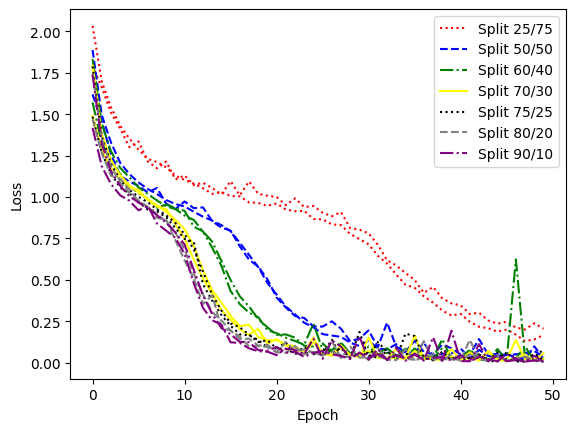

In [24]:
fig,ax = plt.subplots()
ax.plot(hists[0].history['loss'],linestyle = 'dotted',color = 'red',label = 'Split 25/75')
ax.plot(hists[0].history['val_loss'],color = 'red',linestyle = 'dotted')
ax.plot(hists[1].history['loss'],linestyle = 'dashed',color = 'blue',label = 'Split 50/50')
ax.plot(hists[1].history['val_loss'],color = 'blue',linestyle = 'dashed')
ax.plot(hists[2].history['loss'],linestyle = '-.',color = 'green',label = 'Split 60/40')
ax.plot(hists[2].history['val_loss'],color = 'green',linestyle = '-.')
ax.plot(hists[3].history['loss'],linestyle = 'solid',color = 'yellow',label = 'Split 70/30')
ax.plot(hists[3].history['val_loss'],color = 'yellow',linestyle = 'solid')
ax.plot(hists[4].history['loss'],linestyle = 'dotted',color = 'black',label = 'Split 75/25')
ax.plot(hists[4].history['val_loss'],color = 'black',linestyle = 'dotted')
ax.plot(hists[5].history['loss'],linestyle = 'dashed',color = 'grey',label = 'Split 80/20')
ax.plot(hists[5].history['val_loss'],color = 'grey',linestyle = 'dashed')
ax.plot(hists[6].history['loss'],linestyle = '-.',color = 'purple',label = 'Split 90/10')
ax.plot(hists[6].history['val_loss'],color = 'purple',linestyle = '-.')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

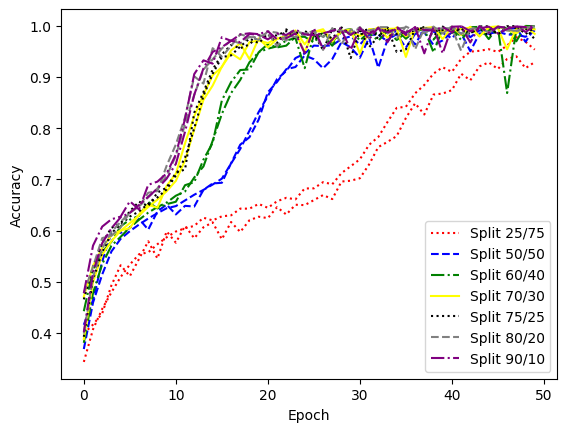

In [27]:
fig,ax = plt.subplots()
ax.plot(hists[0].history['accuracy'],linestyle = 'dotted',color = 'red',label = 'Split 25/75')
ax.plot(hists[0].history['val_accuracy'],color = 'red',linestyle = 'dotted')
ax.plot(hists[1].history['accuracy'],linestyle = 'dashed',color = 'blue',label = 'Split 50/50')
ax.plot(hists[1].history['val_accuracy'],color = 'blue',linestyle = 'dashed')
ax.plot(hists[2].history['accuracy'],linestyle = '-.',color = 'green',label = 'Split 60/40')
ax.plot(hists[2].history['val_accuracy'],color = 'green',linestyle = '-.')
ax.plot(hists[3].history['accuracy'],linestyle = 'solid',color = 'yellow',label = 'Split 70/30')
ax.plot(hists[3].history['val_accuracy'],color = 'yellow',linestyle = 'solid')
ax.plot(hists[4].history['accuracy'],linestyle = 'dotted',color = 'black',label = 'Split 75/25')
ax.plot(hists[4].history['val_accuracy'],color = 'black',linestyle = 'dotted')
ax.plot(hists[5].history['accuracy'],linestyle = 'dashed',color = 'grey',label = 'Split 80/20')
ax.plot(hists[5].history['val_accuracy'],color = 'grey',linestyle = 'dashed')
ax.plot(hists[6].history['accuracy'],linestyle = '-.',color = 'purple',label = 'Split 90/10')
ax.plot(hists[6].history['val_accuracy'],color = 'purple',linestyle = '-.')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

## Using Flatten

In [120]:
## Your code
def build_image2text_model(conv = True):
    image2text = tf.keras.Sequential()
    if conv:
        image2text.add(ConvLSTM2D(filters=4,kernel_size=(3, 3),return_sequences=True,input_shape=(max_query_length, 28, 28, 1)))
        image2text.add(TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))
        image2text.add(ConvLSTM2D(filters=8,kernel_size=(3, 3),return_sequences=True,))
        image2text.add(TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))))
        
        image2text.add(TimeDistributed(Flatten()))
        
        image2text.add(tf.keras.layers.Bidirectional(LSTM(512, return_sequences=True)))
        image2text.add(LSTM(512))

    else:
        
        image2text.add(Flatten(input_shape= (max_query_length,28,28,1)))
        image2text.add(Reshape((5,784)))
        image2text.add(tf.keras.layers.Bidirectional(LSTM(512, return_sequences=True)))
        image2text.add(LSTM(512, return_sequences=True))
        image2text.add(LSTM(512))
        

    image2text.add(RepeatVector(max_answer_length))
    
    image2text.add(LSTM(256, return_sequences=True))

    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    image2text.summary()

    return image2text



In [128]:
img2txt =  build_image2text_model(False)

/home/jaspe/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)            │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 5, 784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 5, 1024)        │     5,312,512 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 5, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_93 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_37 (RepeatVector) │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 3, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_68             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,350,285 (43.30 MB)

 Trainable params: 11,350,285 (43.30 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X_img,y_text_onehot,test_size=0.25, random_state=5)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5, random_state=5)


img2txt_hist = img2txt.fit(
    X_train,y_train,
    validation_data = (X_test,y_test),
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3761 - loss: 1.8580 - val_accuracy: 0.4389 - val_loss: 1.5958
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4650 - loss: 1.4957 - val_accuracy: 0.4796 - val_loss: 1.4333
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5211 - loss: 1.3298 - val_accuracy: 0.5305 - val_loss: 1.3147
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5644 - loss: 1.2069 - val_accuracy: 0.5623 - val_loss: 1.2353
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5985 - loss: 1.1087 - val_accuracy: 0.5799 - val_loss: 1.2006
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6182 - loss: 1.0300 - val_accuracy: 0.6020 - val_loss: 1.1192
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6423 - loss: 0.9704 - val_accuracy: 0.6028 - val_loss: 1.1044
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6598 - loss: 0.9170 - val_a

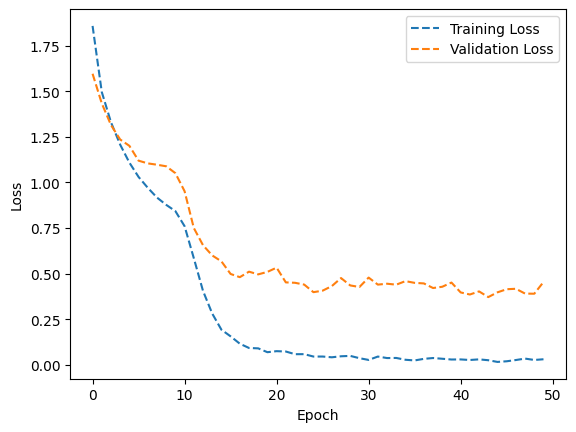

In [130]:
fig,ax = plt.subplots()
ax.plot(img2txt_hist.history['loss'],linestyle = '--',label = 'Training Loss')
ax.plot(img2txt_hist.history['val_loss'],linestyle = '--',label = 'Validation Loss')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

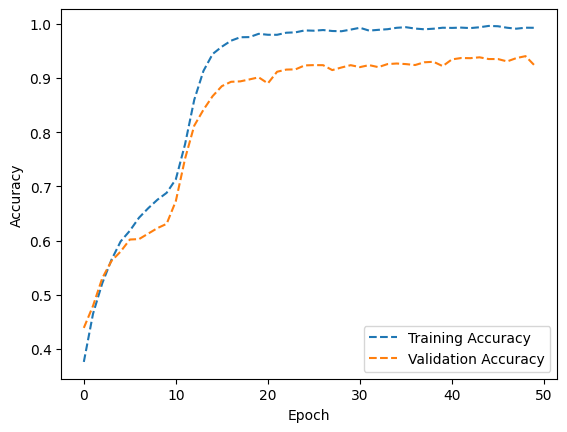

In [131]:
fig,ax = plt.subplots()
ax.plot(img2txt_hist.history['accuracy'],linestyle = '--',label = 'Training Accuracy')
ax.plot(img2txt_hist.history['val_accuracy'],linestyle = '--',label = 'Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


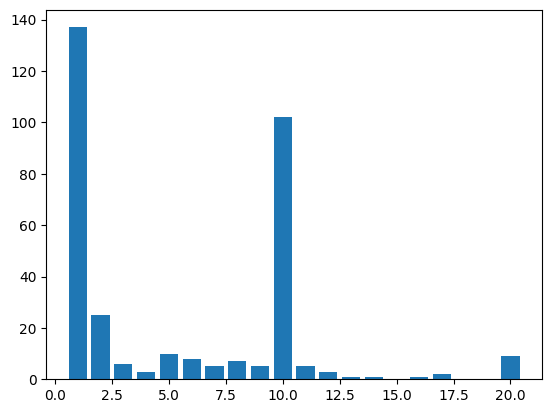

In [137]:
from collections import Counter
pred = decode_labels(img2txt.predict(X_val))
pred = ['0  ' if a == '-  ' else a for a in pred]
true = decode_labels(y_val)
# print(np.where(np.array([abs(int(t)-int(p)) for t, p in zip(true,pred)]) == 800))

results = Counter([abs(int(t)-int(p)) for t, p in zip(true,pred) if t != p])
results = [(k,results[k]) for k in sorted(results.keys())]
fig,ax = plt.subplots()
x = [a[0] for a in results]
y = [a[1] for a in results]
ax.bar(x[:17],y[:17])
plt.show()

In [138]:
results

[(1, 137),
 (2, 25),
 (3, 6),
 (4, 3),
 (5, 10),
 (6, 8),
 (7, 5),
 (8, 7),
 (9, 5),
 (10, 102),
 (11, 5),
 (12, 3),
 (13, 1),
 (14, 1),
 (16, 1),
 (17, 2),
 (20, 9),
 (30, 10),
 (39, 1),
 (40, 5),
 (43, 1),
 (46, 1),
 (50, 14),
 (60, 7),
 (70, 3),
 (80, 2),
 (90, 4),
 (120, 1)]

## Using ConvLSTM2d

In [122]:
img2txt =  build_image2text_model(True)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_25 (ConvLSTM2D)     │ (None, 5, 26, 26, 4)   │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_64             │ (None, 5, 13, 13, 4)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_26 (ConvLSTM2D)     │ (None, 5, 11, 11, 8)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_65             │ (None, 5, 5, 5, 8)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_66             │ (None, 5, 200)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 5, 1024)        │     2,920,448 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 512)            │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_36 (RepeatVector) │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_90 (LSTM)                  │ (None, 3, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_67             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,863,245 (26.18 MB)

 Trainable params: 6,863,245 (26.18 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
X_train,X_test,y_train,y_test = train_test_split(X_img,y_text_onehot,test_size=0.25, random_state=5)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5, random_state=5)


img2txt_hist = img2txt.fit(
    X_train,y_train,
    validation_data = (X_test,y_test),
    epochs = 50,
    batch_size = 32
)

Epoch 1/50


E0000 00:00:1765054562.011035   84739 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_cell_1/mul' -> 'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_cell_1/convolution_6' -> 'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_cell_1/add_6', 'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_cell_1/Sigmoid' -> 'StatefulPartitionedCall/sequential_38_1/conv_lstm2d_26_1/while/body/_255/sequential_38_1/conv_lstm2d_26_1/while/conv_lstm_

469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.3313 - loss: 2.0621 - val_accuracy: 0.3741 - val_loss: 1.9747
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.3848 - loss: 1.8989 - val_accuracy: 0.3915 - val_loss: 1.8192
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.4014 - loss: 1.7710 - val_accuracy: 0.4111 - val_loss: 1.7256
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.4121 - loss: 1.7004 - val_accuracy: 0.4076 - val_loss: 1.6991
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.4235 - loss: 1.6497 - val_accuracy: 0.4276 - val_loss: 1.6348
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.4367 - loss: 1.5942 - val_accuracy: 0.4380 - val_loss: 1.5944
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.4543 - loss: 1.5349 - val_accuracy: 0.4511 - val_loss: 1.5496
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.4700 - loss: 1.4765 - val_accurac

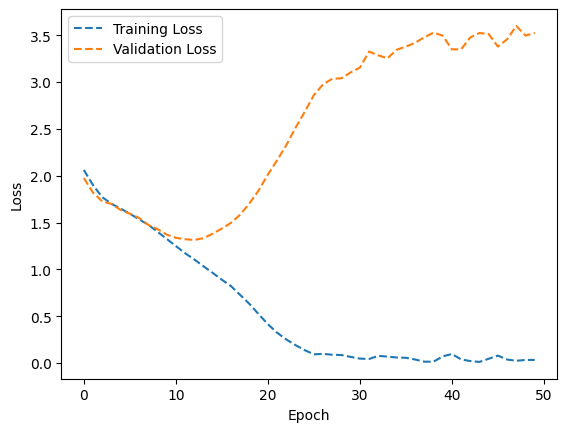

In [124]:
fig,ax = plt.subplots()
# ax1 = ax.twinx()
ax.plot(img2txt_hist.history['loss'],linestyle = '--',label = 'Training Loss')
ax.plot(img2txt_hist.history['val_loss'],linestyle = '--',label = 'Validation Loss')
# ax1.plot(img2txt_hist.history['accuracy'],label = 'Training Accuracy')
# ax1.plot(img2txt_hist.history['val_accuracy'],label = 'Validation Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
# ax1.legend
plt.show()

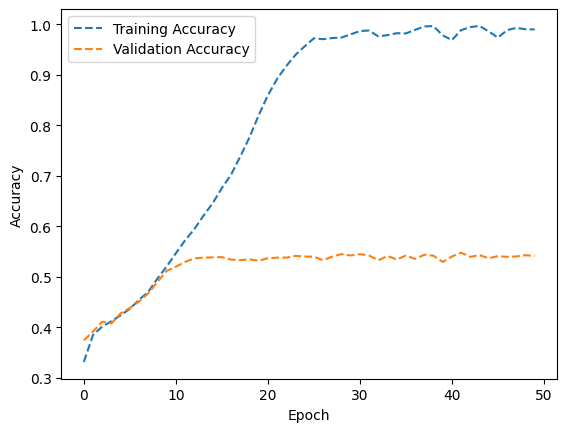

In [125]:
fig,ax = plt.subplots()
ax.plot(img2txt_hist.history['accuracy'],linestyle = '--',label = 'Training Accuracy')
ax.plot(img2txt_hist.history['val_accuracy'],linestyle = '--',label = 'Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code




